In [22]:
import os
import torch
from torchvision import datasets, transforms
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Subset

In [23]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Calculate sizes for training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Define fixed indices for train and test splits
train_indices = list(range(train_size))
test_indices = list(range(train_size, len(dataset)))

# Create Subsets based on these indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_images = dataset.data[train_dataset.indices].numpy()
train_labels = dataset.targets[train_dataset.indices].numpy()
test_images = dataset.data[test_dataset.indices].numpy()
test_labels = dataset.targets[test_dataset.indices].numpy()

In [24]:
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32):
    num_classes = len(np.unique(train_targets))
    client_data_indices = defaultdict(list)
    client_test_indices = defaultdict(list)

    # Partition Train Data and Capture Proportions
    client_proportions = []
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)
        client_proportions.append(proportions)

        # Calculate split sizes and assign indices to each client
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_data_indices[i].extend(indices)

    # Partition Test Data Using the Same Proportions as Train Data
    for c, proportions in enumerate(client_proportions):
        class_indices = np.where(test_targets == c)[0]
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_test_indices[i].extend(indices)

    # Create Federated Loaders
    federated_train_loaders, federated_test_loaders = [], []
    for i in range(num_clients):
        client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_train_loaders.append(train_loader)

        client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loader by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)
    
    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader

In [25]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500,10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Task 3

In [26]:
import torch
import torch.nn.functional as F
import torch.optim as optim

def local_train_scaffold(model, train_loader, c_global, c_local, epochs, lr, mu, device):
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Move control variates to the device
    c_global = {name: c_global[name].to(device) for name in c_global}
    c_local = {name: c_local[name].to(device) for name in c_local}
    
    for epoch in range(epochs):
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)
            loss = F.cross_entropy(output, targets)

            # Backward pass
            loss.backward()

            # Update weights with SCAFFOLD control variates
            for name, param in model.named_parameters():
                param.grad += mu * (c_global[name] - c_local[name])

            optimizer.step()

    # Compute updates and new local control variates
    updated_params = {name: param.clone().detach().to(device) for name, param in model.state_dict().items()}
    c_local_new = {name: c_local[name] + (updated_params[name] - model.state_dict()[name]) / (mu * lr)
                   for name in updated_params}

    model.to("cpu")  # Move model back to CPU if necessary
    return updated_params, c_local_new

def federated_scaffold(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr, device):
    global_model.to(device)

    # Initialize global and local control variates
    c_global = {name: torch.zeros_like(param, device=device) for name, param in global_model.state_dict().items()}
    c_local = [{name: torch.zeros_like(param, device=device) for name, param in global_model.state_dict().items()} 
               for _ in range(num_clients)]

    round_accuracies = []

    for r in range(rounds):
        client_updates = []
        for i in range(num_clients):
            model_copy = SimpleCNN()
            model_copy.load_state_dict(global_model.state_dict())
            updated_params, c_local[i] = local_train_scaffold(
                model_copy, train_loaders[i], c_global, c_local[i], epochs, local_lr, mu=0.001, device=device
            )
            client_updates.append(updated_params)

        # Aggregate updates
        for name in global_model.state_dict():
            global_model.state_dict()[name] = torch.mean(
                torch.stack([client[name].to(device) for client in client_updates]), dim=0
            )

        # Update global control variates
        for name in c_global:
            c_global[name] += torch.mean(
                torch.stack([c_local[i][name].to(device) for i in range(num_clients)]), dim=0
            )

        # Evaluate
        correct, total = 0, 0
        global_model.eval()
        with torch.no_grad():
            for data, targets in test_loaders[0]:
                data, targets = data.to(device), targets.to(device)
                output = global_model(data)
                pred = output.argmax(dim=1)
                correct += (pred == targets).sum().item()
                total += targets.size(0)

        accuracy = 100.0 * correct / total
        round_accuracies.append(accuracy)
        print(f"Round {r + 1}/{rounds}: Accuracy = {accuracy:.2f}%")

    global_model.to("cpu")  # Move model back to CPU if necessary
    return round_accuracies

In [1]:
num_clients = 5
rounds = 3
epochs = 20  # Reduced for quick testing
lr = 0.01
mu = 0.001

def run_scaffold():
    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, 0.1, batch_size=32)
    global_model = SimpleCNN()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    round_accuracies = federated_scaffold(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, lr, device)

    return round_accuracies

alpha_1 = run_scaffold

Round 1/3: Accuracy = 42.27%
Round 2/3: Accuracy = 59.99%
Round 3/3: Accuracy = 62.56%


In [2]:
num_clients = 5
rounds = 3
epochs = 20  # Reduced for quick testing
lr = 0.01
mu = 0.001

def run_scaffold():
    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, 0.5, batch_size=32)
    global_model = SimpleCNN()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    round_accuracies = federated_scaffold(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, lr, device)

    return round_accuracies

alpha_5 = run_scaffold()

Round 1/3: Accuracy = 31.88%
Round 2/3: Accuracy = 63.22%
Round 3/3: Accuracy = 79.13%


In [3]:
num_clients = 5
rounds = 3
epochs = 20  # Reduced for quick testing
lr = 0.01
mu = 0.001

def run_scaffold():
    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, 2, batch_size=32)
    global_model = SimpleCNN()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    round_accuracies = federated_scaffold(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, lr, device)

    return round_accuracies

alpha_2 = run_scaffold()

Round 1/3: Accuracy = 52.16%
Round 2/3: Accuracy = 74.37%
Round 3/3: Accuracy = 88.16%


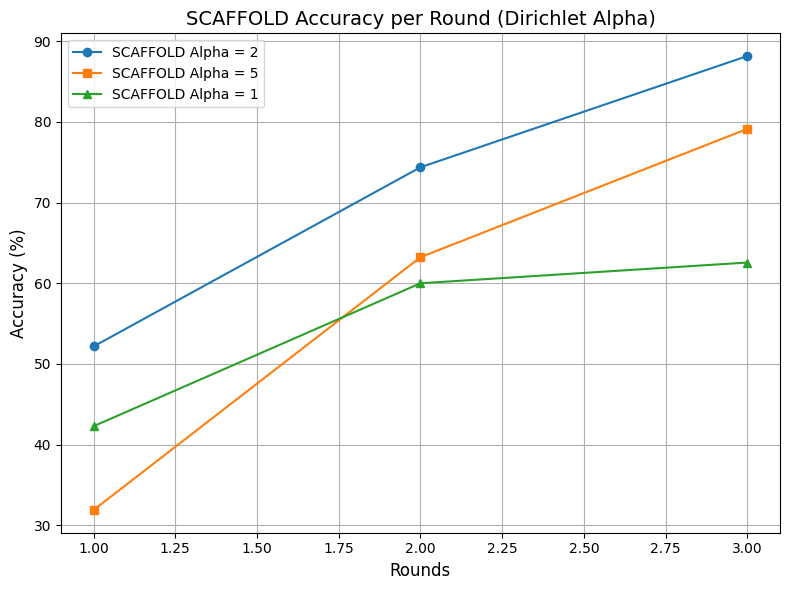

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, 4), alpha_2, marker='o', label='SCAFFOLD Alpha = 2')
plt.plot(range(1, 4), alpha_5, marker='s', label='SCAFFOLD Alpha = 0.5')
plt.plot(range(1, 4), alpha_1, marker='^', label='SCAFFOLD Alpha = 0.11')

plt.xlabel('Rounds', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('SCAFFOLD Accuracy per Round (Dirichlet Alpha)', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
